## PyFolding SI Notebook 4
---

[Authors] ERGM, ARL

---

## Fitting tANK chevron to Three State with fast phase chevron - sharing parameters between models

In this notebook, let's try to fit a complicated model to some example data. Here the idea is to fit two models to two datasets, but share some of the parameters between the two models. In real terms this is difficult to do in most bought fitting software, but we have the full power of a programming language at our disposal.

We can *repurpose* (i.e. hack) the GlobalFit object to do exactly what we want. Let's start by getting some nice data digitised from this paper:

```
Structural insights into an equilibrium folding intermediate of an archaeal ankyrin repeat protein
Low C, Weininger U, Neumann P, Klepsch M, Lilie H, Stubbs MT, and Balbach J
PNAS (2008) 105: 3779–3784
```
[http://www.pnas.org/cgi/doi/10.1073/pnas.0710657105]

Remember, if you are less script/computer orientated, you can simply change the data paths/variables, etc for your proteins and re-run the jupyter notebook ( "Kernal/Restart & Run all" from the menu above).




### Data Format

Please see PyFolding SI Notebooks 1 and 2 for the format your data has to be in to enable this type of analysis.

In [1]:
#First off let's load pyfolding & pyplot into this ipython notebook
# (pyplot allows us to plot more complex figures of our results):

%matplotlib inline
import pyfolding
from pyfolding import models

# let's use some other libraries also
import matplotlib.pyplot as plt
import numpy as np

<IPython.core.display.Javascript object>

PyFolding: Jupyter autoscrolling has been disabled


In [2]:
# loading the data - The kinetics of each protein is in one .csv as per PyFolding SI Notebooks 1 and 2

pth = "../examples/tANK/"
tANK_all = pyfolding.read_kinetic_data(pth,"ChevronAll.csv")

In [3]:
# let's give this dataset a good name
tANK_all.ID = 'Thermophilic AR protein (tANK)'

Let's plot the chevron phases:

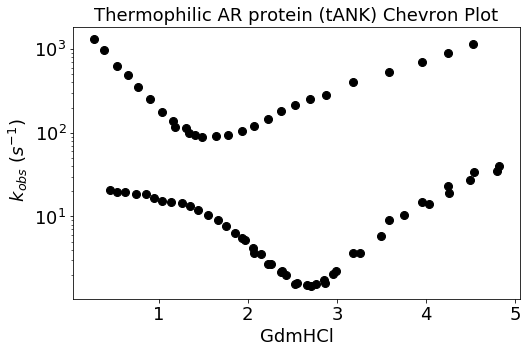

In [4]:
# easy plotting of the entire dataset ...
tANK_all.plot()

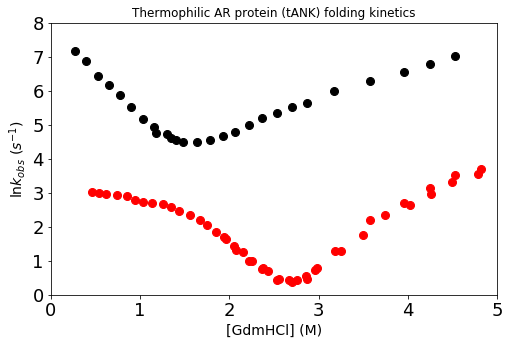

In [5]:
# ...or, custom plotting

k1_x, k1_y = tANK_all.chevron('k1')                            # defines the slower chevron rates
k2_x, k2_y = tANK_all.chevron('k2')                            # defines the faster chevron rates

plt.figure(figsize=(8,5))                                      # makes the figure 8cm by 5cm
plt.plot(k1_x, k1_y, 'ro', markersize=8)                       # red filled circles, sized '8'
plt.plot(k2_x, k2_y, 'ko', markersize=8)                       # black filled circles, sized '8'
plt.rc('xtick', labelsize=14)                                  # fontsize of the x tick labels
plt.rc('ytick', labelsize=14)                                  # fontsize of the y tick labels
plt.ylim([0, 8])                                               # y axis from 0 to 8
plt.xlim([0, 5])                                               # x axis from 0 to 5
plt.grid(False)                                                # no grid on the graph
plt.xlabel('[GdmHCl] (M)', fontsize=14)                        # x axis title with fontsize
plt.ylabel(r'$\ln k_{obs}$ $(s^{-1})$', fontsize=14)           # y axis title with fontsize
plt.title('Thermophilic AR protein (tANK) folding kinetics')   # Plot title
plt.show()


Note that the measurements were performed at $15^\text{o}$C, so we need to adjust the temperature:

In [6]:
pyfolding.set_temperature(15.0)

Set temperature to 15.00°C
(NOTE: Careful, this sets the temperature for all subsequent calculations)


Let's use the three state chevron with fast phase. To do this, we need to share the parameters like this:

1. Fit a "two-state chevron" model to the fast phase, and share those params with:
2. A "three-state with fast phase" model for the slower phase

In [7]:
models.TwoStateChevron().info()

<IPython.core.display.Math object>

 Two state chevron plot.

	Folding Scheme:
		N <-> D

	Params:
		k obs = rate of unfolding or refolding at a particular denaturant concentration
		kf = rate constant of refolding at a particular denaturant concentration
		mf = the gradient of refolding arm of the chevron
		ku = rate constant of unfolding at a a particular denaturant concentration
		mu = the gradient of unfolding arm of the chevron
		x = denaturant concentration (M)

	Notes:
		Jackson SE and Fersht AR.  Folding of chymotrypsin inhibitor 2.
		1. Evidence for a two-state transition.
		Biochemistry (1991) 30(43):10428-10435.
	


In [8]:
models.ThreeStateFastPhaseChevron().info()

<IPython.core.display.Math object>

 Three state chevron with single intermediate.

	Folding Scheme: N <-> I <-> D

	Params:
		k obs = rate of unfolding or refolding at a particular denaturant concentration
		kfi = microscopic rate constant for the conversion of folded to intermediate
		kif = microscopic rate constant for the conversion of intermediate to folded
		kiu = microscopic rate constant for the conversion of intermediate to unfolded
		kui = microscopic rate constant for the conversion of unfolded to intermediate
		Kiu = equilibrium constant for the rapid equilibration between intermediate & unfolded
		mfi = m-value associated with the kinetic transition between folded & intermediate
		mif = m-value associated with the kinetic transition between intermediate & folded
		miu = m-value associated with the kinetic transition between intermediate & unfolded
		mui = m-value associated with the kinetic transition between unfolded & intermediate
		x = denaturant concentration (M)

	Reference:
		Parker et al. An integrate

To do this, we need to create a fast phase model, which is essentially a two state chevron, but where the parameters are represent the folding and unfolding of the intermediate

In [9]:
class FastPhase(pyfolding.FitModel):
    """ Fast phase model
    """
    def __init__(self):
        pyfolding.FitModel.__init__(self)
        fit_args = self.fit_func_args
        self.params = tuple( [(fit_args[i],i) for i in xrange(len(fit_args))] )
        self.default_params = np.array([100., 1.3480, 5e-4, 1.])
        #self.constants = (('mf',1.76408),('mu',1.13725))
        self.verified = True


    def fit_func(self, x, kui, mui, kiu, miu):
        k_obs = kui*np.exp(-mui*x) + kiu*np.exp(miu*x)
        return k_obs

    def error_func(self, y):
        return np.log(y)

### Setting up a custom Global fit

In [10]:
# start by setting up a GlobalFit object
global_fit = pyfolding.GlobalFit()
global_fit.fit_funcs = (models.ThreeStateFastPhaseChevron, FastPhase)
global_fit.x = (k1_x, k2_x) # remember that k1 defines the slower chevron rates & k2 defines are faster chevron rates
global_fit.y = (k1_y, k2_y)
global_fit.ID = ['slow_phase','fast_phase']
global_fit.shared = ['kui', 'mui', 'kiu', 'miu']
global_fit.initialise()


In [11]:
# find out the order of params for p0
print global_fit.params.keys()

['mui', 'miu', 'kui', 'kiu', 'kif_0', 'mif_0', 'kfi_0', 'mfi_0']


In [12]:
# set some reasonable starting parameters for the fit
p0 = np.array([1.7, 0.01, 1860., 2.7, 2652.0, 2.8, 14., 1.])
bounds = ((-5.,0.,0.,-5.,0.,-5.,0.,-5), (5.,1e4,1e4,5.,1e4,4.,1e4,5.))

# run the fit and get the results
_,_ = global_fit.fit(p0=p0, bounds=bounds)
results = global_fit.results


Display the results from the fitting...

In [13]:
for r in results:
    r.display()

Fitting results
ID: slow_phase
Model: ThreeStateFastPhaseChevron
Optimiser: pyfolding.GlobalFit and scipy.optimize.curve_fit
Temperature: 15.00°C

(s) kui 2006.09375 ± 1127.80859 	 95% CI[1721.71071, 2290.47679]
(s) mui    2.31706 ± 0.60933    	 95% CI[   2.16341,    2.47070]
(s) kiu    5.00000 ± 4.89692    	 95% CI[   3.76521,    6.23479]
(s) miu    1.31374 ± 0.29934    	 95% CI[   1.23826,    1.38922]
(f) kif 5952.74442 ± 7494.67357 	 95% CI[4062.92190, 7842.56695]
(f) mif    3.25244 ± 0.60661    	 95% CI[   3.09948,    3.40540]
(f) kfi    0.01224 ± 0.01286    	 95% CI[   0.00900,    0.01548]
(f) mfi    1.73369 ± 0.27591    	 95% CI[   1.66411,    1.80326]
--------------------------------------------------------------------------------
R^2: 0.97937


Fitting results
ID: fast_phase
Model: FastPhase
Optimiser: pyfolding.GlobalFit and scipy.optimize.curve_fit
Temperature: 15.00°C

(s) kui 2006.09375 ± 1095.11151 	 95% CI[1729.83702, 2282.35047]
(s) mui    2.31706 ± 0.59167    	 95% CI[ 

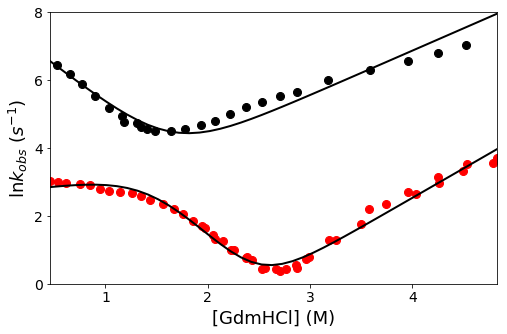

In [14]:
# now that we've fitted the data, plot a figure
plt.figure(figsize=(8,5))
plt.plot(k1_x, k1_y, 'ro', markersize=8)
plt.plot(k2_x, k2_y, 'ko', markersize=8)

# plot each of the chevrons...
for r in results:
    plt.plot(r.x_fit, r.y_fit, 'k-', linewidth=2)

plt.xlim([min(k1_x), max(k1_x)])
plt.rc('xtick', labelsize=18)    # fontsize of the x tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the y tick labels
plt.grid(False)
plt.xlabel('[GdmHCl] (M)', fontsize=18)
plt.ylabel(r'$\ln k_{obs}$ $(s^{-1})$', fontsize=18)
plt.ylim([0, 8])
plt.show()

---
### We can also output this with the  "prettier" graphics showing chevron & equilibrium curves together
(as in PyFolding SI Notebook 1)

### 1st  - we need to add the results to the protein object

In [15]:
tANK_all.results = results[0]
tANK_all.components = {'fast': np.exp(results[1].y_fit)}
tANK_all.fit_func = models.ThreeStateFastPhaseChevron

### 2nd - lets get the equilibrium data & fit to a three state model

Fitting results
ID: tANK_equilmFluorscence
Model: ThreeStateEquilibrium
Optimiser: pyfolding.GlobalFit and scipy.optimize.curve_fit
Temperature: 15.00°C

(f) Y_N   324.75027 ± 126.42041  	 95% CI[ 293.09646,  356.40409]
(f) Y_I   197.11446 ± 606.73632  	 95% CI[  45.19660,  349.03233]
(f) Y_D    66.56156 ± 129.35140  	 95% CI[  34.17386,   98.94925]
(f) DGni    4.77711 ± 36.70045   	 95% CI[  -4.41214,   13.96636]
(f) m_ni    2.96838 ± 25.39792   	 95% CI[  -3.39088,    9.32765]
(f) DGid    8.33336 ± 76.09964   	 95% CI[ -10.72088,   27.38759]
(f) m_id    3.09530 ± 26.57293   	 95% CI[  -3.55817,    9.74877]
--------------------------------------------------------------------------------
R^2: 0.99983




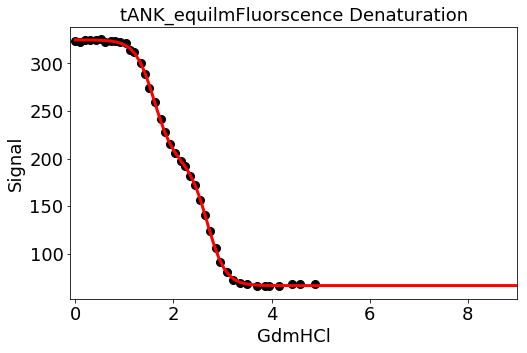

In [16]:
#1st load the data by adding the equilibrium
tank_Equilm = pyfolding.read_equilibrium_data(pth, "tANK_equilmFluorscence.csv")

#then select the fit function and associate it with the data
tank_Equilm.fit_func = models.ThreeStateEquilibrium

# Fit it with parameters (as the defaults ones are not close enough)
tank_Equilm.fit(p0=[350,2,25,18.5,11.6,34,12.6])

# Plot the figure to check
tank_Equilm.plot()


### 3rd - lets plot both together & print out to pdf

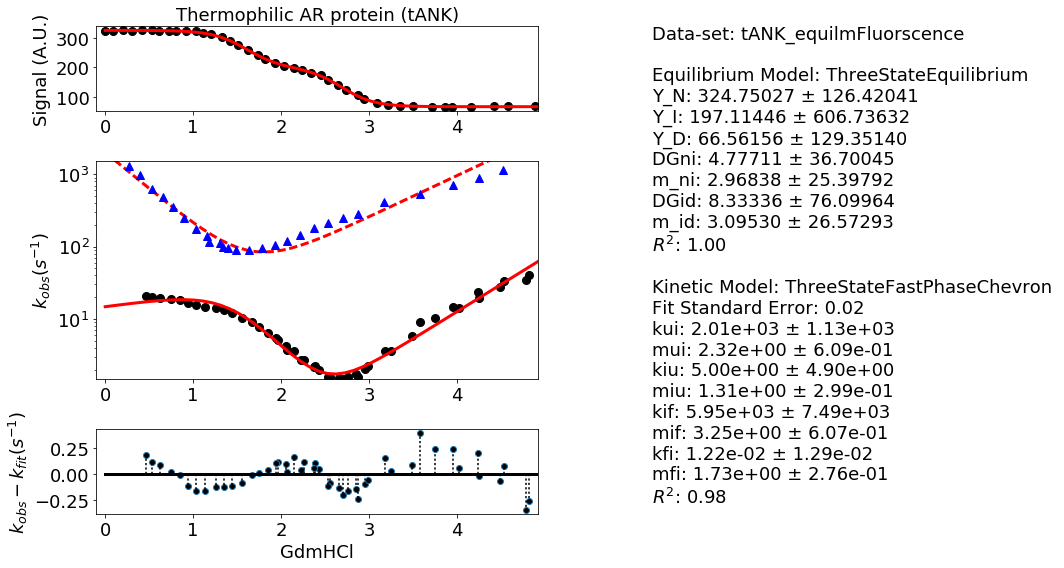

In [17]:
pyfolding.plot_figure(tank_Equilm, tANK_all, display=True)


---

### End of this Notebook.

---